# Create Map

Here you can create a map of a country that is divided into a certain number of areas with the same population. The split lines run at a defined angle. To create animated maps, the process can be automated for a range of angles at the end of this notebook.

I don't know if my solution is the most efficient way to do this, but it seems to work 😁

I have tried to structure this file so that you can roughly understand how the process works.

## Import Libraries

In [1]:
import geopandas as gpd
import numpy as np
import shapely.get_coordinates
import shapely.ops
from shapely import Point, LineString, Polygon, MultiPolygon

## Parameters

You can set the following parameters here:
- SPLIT_ANGLE: The angle in degrees at which the areas are separated, where 0 degrees corresponds to a horizontal line. Set a value between -90 and 90.
- NUMBER_AREAS: The number of areas with the same population. Set a value greater than or equal to 2.
- COUNTRY_BOUNDARY_PATH: The location of the file with the country borders, which can be downloaded from https://www.geoboundaries.org/simplifiedDownloads.html as in preprocessing. Use AMD1 data if you want to include state borders in your visualization.

In [14]:
SPLIT_ANGLE = -90
NUMBER_AREAS = 4
COUNTRY_BOUNDARY_PATH = "../data/external/geoBoundaries-AUT-ADM1_simplified.geojson"

POPULATION_POINTS_PATH = "../data/processed/population_points.gpkg"
RESULT_FILE = "../data/result/country_splitted.gpkg"

## Helper Functions

In [3]:
def create_line_with_angle_and_length(starting_point, angle, length):
    """Create a line with a given starting position, angle and length."""
    end_point = Point(
        starting_point.x + length * np.cos(angle),
        starting_point.y + length * np.sin(angle),
    )
    line = LineString([starting_point, end_point])

    return line

def scalar_projection(projection_line, point):
    """Project a point on a line and return the distance of the point on this
    line from its starting point.
    
    The functionality is described here:
    https://en.wikipedia.org/wiki/Scalar_projection
    """
    starting_point = np.array(projection_line.coords)[0]
    end_point = np.array(projection_line.coords)[-1]

    vector = end_point - starting_point

    dot_product = np.dot(vector, shapely.get_coordinates(point)[0] - starting_point)
    scalar = dot_product / np.linalg.norm(vector)

    return scalar

def get_coordinates_from_scalar(projection_line, projection_angle, scalar):
    """Calculate a points coordinates based on its distance on a line from its
    starting point.
    """
    starting_point = np.array(projection_line.coords)[0]
    coordinates = Point(
        np.cos(projection_angle) * scalar + starting_point[0],
        np.sin(projection_angle) * scalar + starting_point[1]
    )

    return coordinates

## Read Data

The population data is represented by a point layer, with each point containing the number of people living in the corresponding grid cell. The dataset is generated in the preprocessing notebook file and loaded here.

In [4]:
population_points = gpd.read_file(POPULATION_POINTS_PATH, layer="Population Points")

# Get the coordinate reference system
grid_crs = population_points.crs

population_points.head()

,Population Count,geometry
0,2,POINT (4687500.000 2890500.000)
1,2,POINT (4688500.000 2890500.000)
2,0,POINT (4690500.000 2890500.000)
3,0,POINT (4686500.000 2889500.000)
4,0,POINT (4687500.000 2889500.000)


The country baundary is loaded here.

Text(0.5, 1.0, 'Country Border')

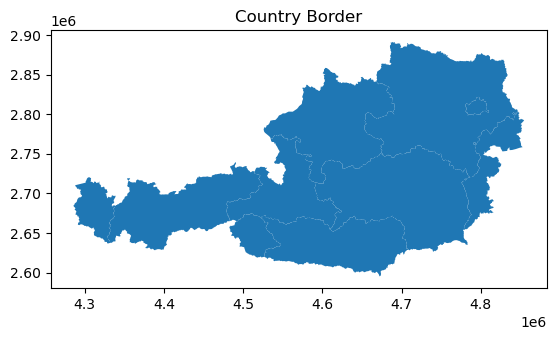

In [5]:
country_boundary = gpd.read_file(COUNTRY_BOUNDARY_PATH)
country_boundary = country_boundary.to_crs(grid_crs)

# Plot
ax = country_boundary.plot()
ax.set_title("Country Border")

## Calculate Variables

In [6]:
# Convert degree angle to radians
split_angle_rad = np.deg2rad(SPLIT_ANGLE)

# Get total population of country
total_pop = sum(population_points["Population Count"])

# Get country bounds
country_bounds = population_points.total_bounds
left = country_bounds[0]
right = country_bounds[2]
bottom = country_bounds[1]
top = country_bounds[3]

# Get x and y size of the country bounds
x_size = right - left
y_size = top - bottom

## Create Projection Line

A line is created that runs perpendicular to the direction of the desired area splits.

In [7]:
def create_projection_line(population_points, angle, line_length):
    # Calculate projection angle so that the projection line is always right from its starting point
    if angle < 0:
        projection_angle = angle + (np.pi / 2)
    else:
        projection_angle = angle - (np.pi / 2)

    starting_point = Point(country_bounds[0], country_bounds[1])
    
    projection_line = create_line_with_angle_and_length(starting_point, projection_angle, line_length)

    return projection_line, projection_angle

Text(0.5, 1.0, 'Projection Line')

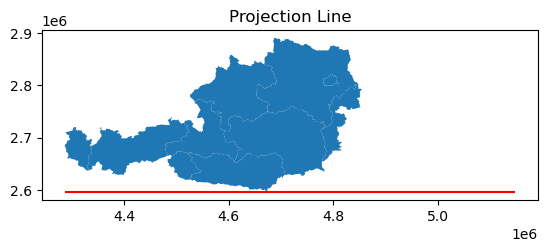

In [65]:
projection_line, projection_angle = create_projection_line(population_points, split_angle_rad, x_size + y_size)

# Plot
ax = country_boundary.plot()
gpd.GeoSeries(projection_line, crs=grid_crs).plot(ax=ax, color="red")
ax.set_title("Projection Line")

## Project Population Points on Line

The population points are projected onto this line and sorted according to the distance from the starting point of the projection line.

In [8]:
def project_points_on_line(population_points, projection_line):
    distances = []

    for point in population_points.geometry:
        distance = scalar_projection(projection_line, point)
        distances.append(distance)

    sorted_indexes = np.argsort(distances)
    sorted_population_values = np.array(population_points["Population Count"])[sorted_indexes]
    sorted_distances = np.array(distances)[sorted_indexes]

    return sorted_population_values, sorted_distances

In [67]:
sorted_population_values, sorted_distances = project_points_on_line(population_points, projection_line)

## Find Breaks

The number of people living in each area with the same population is calculated by a simple division. The population points sorted on the projection line are iterated through to determine the points that lie on the split edges of these areas.

In [9]:
def find_break_coordinates(total_pop, sorted_distances, sorted_population_values, projection_line, projection_angle):
    # Get number of people per area
    population_per_area = int(total_pop / (NUMBER_AREAS))

    population_summed = 0
    current_point = 0

    break_coordinates = []

    # Algorithm is performed for each split
    for split in range(NUMBER_AREAS - 1):
        # Get population value of the next split
        break_value = population_per_area * (split + 1)
        # Iterate over each population point with its distance on the projection line, starting at the point of the last split
        for distance, population in zip(sorted_distances[current_point:], sorted_population_values[current_point:]):
            # Cumulate population
            population_summed += population
            current_point += 1
            # If the break point is reached, get its coordinates and look for the next split
            if population_summed >= break_value:
                break_coordinates.append(get_coordinates_from_scalar(projection_line, projection_angle, distance))
                break

    return break_coordinates

Break Coordinates: [<POINT (4637500 2595500)>, <POINT (4781500 2595500)>]


(2585500.0, 2900500.0)

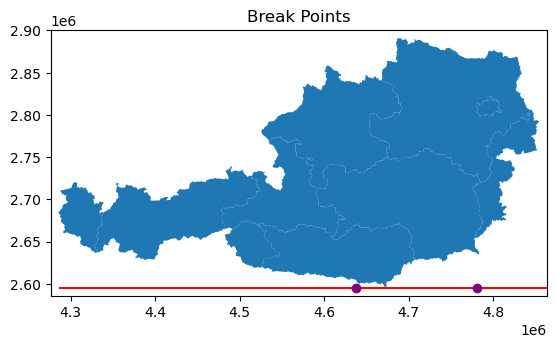

In [69]:
break_coordinates = find_break_coordinates(total_pop, sorted_distances, sorted_population_values, projection_line, projection_angle)

print(f"Break Coordinates: {break_coordinates}")

# Plot
ax = country_boundary.plot()
gpd.GeoSeries(projection_line, crs=grid_crs).plot(ax=ax, color="red")
gpd.GeoSeries(break_coordinates, crs=grid_crs).plot(ax=ax, color="purple", zorder=3)
ax.set_title("Break Points")
ax.set_xlim([left-10000, right+10000])
ax.set_ylim([bottom-10000, top+10000])

## Get Break Lines

The break points can be used to create the break lines in the direction of the split angle.

In [10]:
def get_break_lines(break_coordinates, split_angle_rad):
    break_lines = []

    for coordinates in break_coordinates:
        break_line_start = create_line_with_angle_and_length(coordinates, split_angle_rad, x_size + y_size)
        break_line_end = create_line_with_angle_and_length(coordinates, split_angle_rad + np.pi, x_size + y_size)
        break_line = LineString([np.array(break_line_start.coords[1]), np.array(break_line_end.coords[1])])

        break_lines.append(break_line)
    
    return break_lines

(2585500.0, 2900500.0)

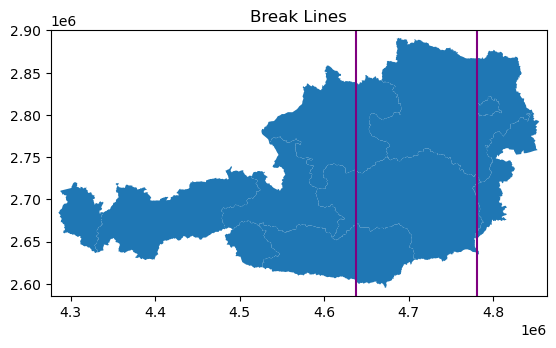

In [71]:
break_lines = get_break_lines(break_coordinates, split_angle_rad)

# Plot
ax = country_boundary.plot()
gpd.GeoSeries(break_lines, crs=grid_crs).plot(ax=ax, color="purple")
ax.set_title("Break Lines")
ax.set_xlim([left-10000, right+10000])
ax.set_ylim([bottom-10000, top+10000])

## Get Intersection Polygon

A rectangular polygon is created which is divided by the break lines.

In [11]:
def get_intersection_polygon(break_lines, split_angle):
    polygon_offset = 10000

    polygon_points = [
        [left, top],
        [right, top],
        [right, bottom],
        [left, bottom],
    ]
    boundary_polygon = Polygon(polygon_points).buffer(polygon_offset, cap_style="square")

    for break_line in break_lines:
        boundary_polygon = MultiPolygon(shapely.ops.split(boundary_polygon, break_line))

    polygon_data = {
        "Split": [*range(1, NUMBER_AREAS+1)],
        "Angle": [split_angle] * NUMBER_AREAS,
        "geometry": boundary_polygon.geoms}
    intersection_polygon = gpd.GeoDataFrame(data=polygon_data, crs=grid_crs)
    
    return intersection_polygon

{'Split': [1, 2, 3], 'Angle': [-90, -90, -90], 'geometry': <shapely.geometry.base.GeometrySequence object at 0x000001C05400F2D0>}


Text(0.5, 1.0, 'Intersection Polygon')

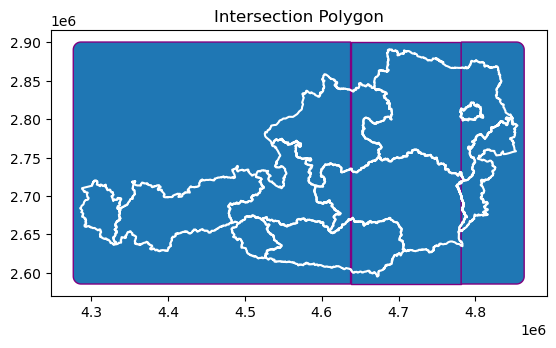

In [73]:
intersection_polygon = get_intersection_polygon(break_lines, SPLIT_ANGLE)

# Plot
ax = intersection_polygon.plot(edgecolor="purple")
country_boundary.boundary.plot(ax=ax, color="white")
ax.set_title("Intersection Polygon")

## Intersect Country Polygon

The polygon is intersected with the country polygon.

Text(0.5, 1.0, 'Divided Country Polygon')

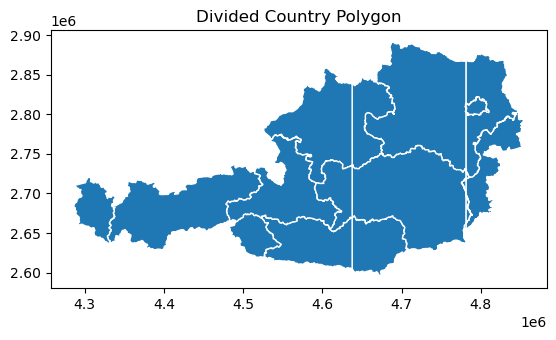

In [47]:
divided_country_polygon = country_boundary.overlay(intersection_polygon, how="intersection")

# Plot
ax = divided_country_polygon.plot(edgecolor="white")
ax.set_title("Divided Country Polygon")

## Save Result

In [22]:
if SPLIT_ANGLE > 0:
    layer_name = f"{str(SPLIT_ANGLE)}deg_{str(NUMBER_AREAS)}areas"
else:
    layer_name = f"minus{str(abs(SPLIT_ANGLE))}deg_{str(NUMBER_AREAS)}areas"

divided_country_polygon.to_file(RESULT_FILE, layer=layer_name)

## Animation

To create polygons for animated splits that rotate 360 degrees, the functions from before are called several times and the result is saved automatically.

In [12]:
duration = 3
fps = 15
frames = int(duration * fps)
angles = np.linspace(-90, 90, frames, endpoint=False)

In [ ]:
for angle in angles:
    print(f"Angle: {str(angle)}°")
    
    split_angle_rad = np.deg2rad(angle)
    projection_line, projection_angle = create_projection_line(population_points, split_angle_rad, x_size + y_size)
    sorted_population_values, sorted_distances = project_points_on_line(population_points, projection_line)
    break_coordinates = find_break_coordinates(total_pop, sorted_distances, sorted_population_values, projection_line, projection_angle)
    break_lines = get_break_lines(break_coordinates, split_angle_rad)
    intersection_polygon = get_intersection_polygon(break_lines, angle)
    country_polygons = country_boundary.overlay(intersection_polygon, how="intersection")

    if angle > 0:
        layer_name = f"{str(angle)}deg_{str(NUMBER_AREAS)}areas"
    else:
        layer_name = f"minus{str(abs(angle))}deg_{str(NUMBER_AREAS)}areas"
    country_polygons.to_file(RESULT_FILE, layer=layer_name)